# Comprendre et manipuler les embeddings

Dans le notebook précédent, nous avons vu comment un texte est transformé en tokens puis en identifiants numériques.

Ces identifiants sont arbitraires : ils ne contiennent aucune information sémantique.

Dans ce notebook, nous allons comprendre comment ces identifiants deviennent des vecteurs numériques capables de représenter le sens.

Nous commencerons par les word embeddings classiques avec Word2Vec, puis nous ferons la transition vers les embeddings utilisés dans les modèles de langage modernes.


____

## Pourquoi les embeddings ?

Considérons les token IDs suivants : [15745, 4205, 382, 261, 10526]

Ces nombres n’ont aucune relation mathématique entre eux. Le modèle a besoin d’une représentation dense et structurée pour apprendre des relations entre mots.

Un embedding est un vecteur dense associé à chaque token.


## Matrice d'embedding

In [3]:
import numpy as np

# Supposons un vocabulaire de 5 tokens
vocab_size = 5
embedding_dim = 4

# Matrice d'embedding aléatoire
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

embedding_matrix

array([[0.43770902, 0.42238258, 0.49433079, 0.71719917],
       [0.03416924, 0.34834692, 0.89392209, 0.84209969],
       [0.52988088, 0.03042663, 0.55453657, 0.1743212 ],
       [0.61297467, 0.63432835, 0.16289286, 0.33030735],
       [0.1597706 , 0.25827432, 0.80620816, 0.46777945]])

In [4]:
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (5, 4)


____

# Word embeddings

In [6]:
import gensim.downloader as api

# Le modèle word2vec-google-news-300 est volumineux (~1.6 Go).
#model = api.load("word2vec-google-news-300")

# Le modèle glove-wiki-gigaword-50 est plus léger (~70 Mo).
model = api.load("glove-wiki-gigaword-50")
word_vectors = model


Ce modèle associe chaque mot à un vecteur de dimension 50.

Il a été entraîné sur Wikipedia et Gigaword.

Il est beaucoup plus léger que Word2Vec Google News, mais il permet d’illustrer exactement les mêmes concepts.


In [9]:
vector = word_vectors["king"] # On récupère le vecteur d'embedding du mot "king"
print(vector) # Affiche le vecteur d'embedding du mot "king"
print("Dimension du vecteur :", len(vector)) # Affiche la dimension du vecteur d'embedding du mot "king"

[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012  -0.076666  1.493    -0.034189 -0.98173
  0.68229   0.81722  -0.51874  -0.31503  -0.55809   0.66421   0.1961
 -0.13495  -0.11476  -0.30344   0.41177  -2.223    -1.0756   -1.0783
 -0.34354   0.33505   1.9927   -0.04234  -0.64319   0.71125   0.49159
  0.16754   0.34344  -0.25663  -0.8523    0.1661    0.40102   1.1685
 -1.0137   -0.21585  -0.15155   0.78321  -0.91241  -1.6106   -0.64426
 -0.51042 ]
Dimension du vecteur : 50


In [ ]:
result = word_vectors.most_similar( # On cherche les mots les plus similaires selon un critère
    positive=["king", "woman"], # On cherche un mot qui est à "king" et "woman"
    negative=["man"], # On cherche un mot qui est à "king" et "woman" mais pas à "man"
    topn=5 # On veut les 5 mots les plus similaires selon ce critère
)

print(result)


[('queen', 0.8523604273796082), ('throne', 0.7664334177970886), ('prince', 0.7592144012451172), ('daughter', 0.7473883628845215), ('elizabeth', 0.7460219860076904)]


Le modèle calcule un nouveau vecteur :

```
king + woman - man
```

Puis retourne les mots les plus proches de ce vecteur.

Cela montre que certaines relations sémantiques sont encodées
comme des directions dans l’espace vectoriel.


### Similarité cosinus

In [10]:
pairs = [
    ("king", "queen"),
    ("man", "woman"),
    ("computer", "keyboard"),
    ("king", "computer")
]

for w1, w2 in pairs:
    sim = word_vectors.similarity(w1, w2)
    print(w1, w2, sim)

king queen 0.7839043
man woman 0.8860338
computer keyboard 0.5768126
king computer 0.22757


La similarité cosinus mesure l’angle entre deux vecteurs.

Une valeur proche de 1 indique une forte proximité sémantique.


### Visualisation simple

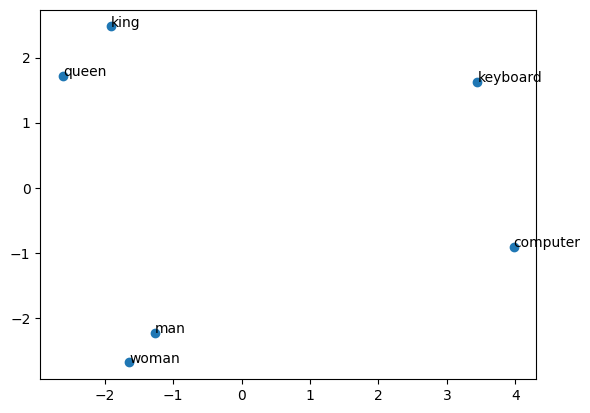

In [11]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = ["king", "queen", "man", "woman", "computer", "keyboard"]

vectors = np.array([word_vectors[w] for w in words])

pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

plt.figure()
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]))

plt.show()


La projection 2D déforme l’espace réel (qui est en 50 dimensions), mais elle permet d’illustrer que les mots proches sémantiquement tendent à être proches géométriquement.


____

# Token et positional embeddings avec PyTorch

## Token Embeddings

In [26]:
import torch
import torch.nn as nn

vocab_size = 10 # Supposons un vocabulaire de 10 tokens
embedding_dim = 3 # Chaque token sera représenté par un vecteur de dimension 3

torch.manual_seed(123) # Pour la reproductibilité, on fixe la graine aléatoire

# Crée une couche d'embedding avec un vocabulaire de 10 tokens et des vecteurs de dimension 3
embedding_layer = nn.Embedding(vocab_size, embedding_dim) 
# Affiche les poids de la couche d'embedding
print(embedding_layer.weight)



Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035],
        [-0.5880,  0.3486,  0.6603],
        [-0.2196, -0.3792,  0.7671],
        [-1.1925,  0.6984, -1.4097],
        [ 0.1794,  1.8951,  1.3689],
        [-1.6033, -1.3250,  0.1784],
        [-2.1338,  1.0524, -0.3885],
        [-0.9343,  1.8319, -0.3378],
        [ 0.8805,  1.5542,  0.6266],
        [-0.1755,  0.0983, -0.0935]], requires_grad=True)


Nous simulons maintenant une séquence de trois tokens représentée par leurs identifiants :

In [27]:
token_ids = torch.tensor([1, 5, 8])
print("Token IDs :", token_ids)


Token IDs : tensor([1, 5, 8])


On récupère leurs embeddings :

In [28]:
# Récupère les embeddings correspondants aux token IDs
token_embeddings = embedding_layer(token_ids)

print(token_embeddings.shape) # Affiche la forme des embeddings récupérés
print(token_embeddings) # Affiche les embeddings récupérés pour les token IDs [1, 5, 8]

torch.Size([3, 3])
tensor([[-0.5880,  0.3486,  0.6603],
        [-1.6033, -1.3250,  0.1784],
        [ 0.8805,  1.5542,  0.6266]], grad_fn=<EmbeddingBackward0>)


`token_embeddings` est maintenant une matrice de forme (longueur_sequence, dimension_embedding).

Chaque ligne correspond à un token de la séquence.
Ces vecteurs contiennent l’information sémantique, mais pas l’ordre.


In [19]:
# Affiche les poids de la couche d'embedding (les vecteurs d'embedding pour chaque token)
print(embedding_layer.weight)
print('\n')
# Affiche le vecteur d'embedding pour le token 3
print(embedding_layer(torch.tensor([3]))) 
print('\n')
# Affiche les vecteurs d'embedding pour les tokens 3, 5 et 7
print(embedding_layer(torch.tensor([3, 5, 7])))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.3035],
        [-0.5880,  0.3486,  0.6603],
        [-0.2196, -0.3792,  0.7671],
        [-1.1925,  0.6984, -1.4097],
        [ 0.1794,  1.8951,  1.3689],
        [-1.6033, -1.3250,  0.1784],
        [-2.1338,  1.0524, -0.3885],
        [-0.9343,  1.8319, -0.3378],
        [ 0.8805,  1.5542,  0.6266],
        [-0.1755,  0.0983, -0.0935]], requires_grad=True)


tensor([[-1.1925,  0.6984, -1.4097]], grad_fn=<EmbeddingBackward0>)


tensor([[-1.1925,  0.6984, -1.4097],
        [-1.6033, -1.3250,  0.1784],
        [-0.9343,  1.8319, -0.3378]], grad_fn=<EmbeddingBackward0>)


Une couche d’embedding est simplement une matrice de paramètres appris.

Un identifiant numérique sert d’index pour récupérer une ligne.

Contrairement à GloVe, ces vecteurs ne sont pas fixes.
Ils sont ajustés pendant l’entraînement du modèle.


## Positional Embeddings

Les token embeddings représentent le sens des mots, mais ils ne contiennent
aucune information sur l’ordre dans lequel les mots apparaissent.

Considérons les deux phrases suivantes :

The dog jumps on the cat.  
The cat jumps on the dog.

Elles contiennent exactement les mêmes tokens.
Pourtant, leur signification est très différente.

Si le modèle ne reçoit que des embeddings de tokens,
il ne peut pas distinguer ces deux phrases.

Il est donc nécessaire d’ajouter une information de position.

Pour cela, nous créons maintenant une seconde couche d’embedding, mais cette fois pour représenter les positions dans la séquence.

La taille du vocabulaire devient la longueur maximale de la séquence.

Chaque position possède son propre vecteur.

La dimension doit être identique à celle des embeddings de tokens afin que les deux puissent être additionnés.



In [20]:
# Supposons que nous avons une séquence de longueur 3
max_length = 3
# Crée une couche d'embedding pour les positions avec une dimension d'embedding de 3
pos_embedding_layer = nn.Embedding(max_length, embedding_dim)

# Affiche les poids de la couche d'embedding pour les positions
position_ids = torch.arange(max_length)
# Affiche les IDs de position
print("Position IDs :", position_ids)

# Récupère les embeddings pour les positions
pos_embeddings = pos_embedding_layer(position_ids)

# Affiche la forme et les embeddings pour les positions
print(pos_embeddings.shape)
print(pos_embeddings)


Position IDs : tensor([0, 1, 2])
torch.Size([3, 3])
tensor([[-0.9178,  0.9045, -2.0975],
        [ 1.1558, -1.2157,  0.1295],
        [ 0.0967,  1.4086,  0.1915]], grad_fn=<EmbeddingBackward0>)


Chaque ligne correspond maintenant à une position dans la séquence.

Pour chaque token à la position i :

1. On récupère son embedding de token.
2. On récupère l’embedding correspondant à sa position.
3. On additionne les deux vecteurs élément par élément.

Le résultat est un vecteur unique qui encode à la fois
le sens du token et sa position dans la phrase.


In [21]:
input_embeddings = token_embeddings + pos_embeddings

print(input_embeddings.shape)
print(input_embeddings)


torch.Size([3, 3])
tensor([[-1.5058,  1.2531, -1.4372],
        [-0.4475, -2.5406,  0.3080],
        [ 0.9772,  2.9627,  0.8182]], grad_fn=<AddBackward0>)


Les vecteurs résultants sont les véritables entrées du Transformer.

Le modèle ne manipule plus :
- des identifiants de tokens
- ni des indices de position

Il travaille uniquement avec des vecteurs combinant
information sémantique et information d’ordre.


## Exemple d'application

Prenons une phrase très simple : `Le chat dort`

Imaginons que notre tokenizer ait déjà transformé cette phrase en identifiants : 

Le    → 2  
chat  → 7  
dort  → 4

On simule donc :

In [22]:
# Phrase simulée
token_ids = torch.tensor([2, 7, 4])
print("Token IDs :", token_ids)

Token IDs : tensor([2, 7, 4])


On crée une couche d'embedding pour les tokens : 

In [23]:
vocab_size = 20
embedding_dim = 4

torch.manual_seed(42)
token_embedding_layer = nn.Embedding(vocab_size, embedding_dim)

token_embeddings = token_embedding_layer(token_ids)

print("Token embeddings :")
print(token_embeddings)
print("Shape :", token_embeddings.shape)


Token embeddings :
tensor([[-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [ 1.6423, -0.1596, -0.4974,  0.4396]], grad_fn=<EmbeddingBackward0>)
Shape : torch.Size([3, 4])


À ce stade :

Chaque mot a un vecteur.
Mais rien dans ces vecteurs n’indique que :

"Le" est en position 0

"chat" est en position 1

"dort" est en position 2

Si on mélange l’ordre : `dort chat Le` alors les embeddings seraient les mêmes, juste permutés.

Le modèle ne comprendrait pas la différence structurelle. On crée donc une seconde couche d’embedding pour représenter les positions.

In [24]:
sequence_length = len(token_ids)

position_embedding_layer = nn.Embedding(sequence_length, embedding_dim)

position_ids = torch.arange(sequence_length)

position_embeddings = position_embedding_layer(position_ids)

print("Position embeddings :")
print(position_embeddings)


Position embeddings :
tensor([[ 0.4679, -0.2049, -0.7409,  0.3618],
        [ 1.9199, -0.2254, -0.3417,  0.3040],
        [-0.6890, -1.1267, -0.2858, -1.0935]], grad_fn=<EmbeddingBackward0>)


Ici :

* Position 0 a son propre vecteur
* Position 1 a son propre vecteur
* Position 2 a son propre vecteur

Et on peut donc combiner les deux informations : 

In [25]:
input_embeddings = token_embeddings + position_embeddings

print("Embeddings finaux envoyés au Transformer :")
print(input_embeddings)


Embeddings finaux envoyés au Transformer :
tensor([[-0.2842,  1.4438, -1.1334, -1.0418],
        [ 1.6883, -0.1836, -0.5933,  1.1639],
        [ 0.9533, -1.2863, -0.7832, -0.6539]], grad_fn=<AddBackward0>)


Maintenant chaque vecteur encode :

* le sens du mot
* sa position dans la phrase